# 1.16a: Wordybird Kick Analysis

**Goal:** Understand the kinematics of token escape—the "kicks" that send trained tokens flying away from the untrained cluster.

## Questions

1. **Displacement:** How far do tokens actually travel vs straight-line distance?
2. **Acceleration:** What's the distribution of kicks? When do they happen?
3. **Multiple kicks:** Do some tokens get kicked more than once?
4. **Directionality:** Are kicks radial (outward explosion) or tangential (orbital drift)?
5. **Surprises:** Bimodal distributions? Synchronization? Phase transitions?

## Kinematics Definitions

For each token $i$ at timestep $t$:

- **Position:** $\mathbf{W}_i(t)$
- **Velocity:** $\mathbf{v}_i(t) = \mathbf{W}_i(t+1) - \mathbf{W}_i(t)$
- **Speed:** $v_i(t) = \|\mathbf{v}_i(t)\|$
- **Acceleration:** $a_i(t) = v_i(t+1) - v_i(t)$ (change in speed)

## Radial Decomposition

Origin = centroid of untrained tokens at $t=0$

- **Radial direction:** $\hat{\mathbf{r}}_i(t) = \frac{\mathbf{W}_i(t) - \mathbf{c}_0}{\|\mathbf{W}_i(t) - \mathbf{c}_0\|}$
- **Radial velocity:** $v_r = \mathbf{v}_i \cdot \hat{\mathbf{r}}_i$ (positive = moving away, negative = moving toward)
- **Tangential velocity:** $v_t = \sqrt{v^2 - v_r^2}$ (perpendicular to radius)

## Parameters

In [14]:
# Training data
TRAINING_DATA_PATH = "../tensors/Wordybird/1.12c_wordybird_1.safetensors"
TOKEN_MASK_PATH = "../tensors/Wordybird/fineweb_token_masks.safetensors"

# Kick detection threshold (standard deviations above mean)
KICK_THRESHOLD_SIGMA = 2.0

# Visualization
PLOT_DPI = 250
COLORMAP = 'inferno'

## Imports

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import load_file
from scipy import stats

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [16]:
print("Loading training data...\n")

# Training data
data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings'].float()  # (n_steps, vocab_size, hidden_dim)
n_steps, vocab_size, hidden_dim = embeddings.shape

# Token masks
mask_data = load_file(TOKEN_MASK_PATH)
trained_indices = mask_data['trained_indices']
untrained_indices = mask_data['untrained_indices']

n_trained = len(trained_indices)
n_untrained = len(untrained_indices)

print(f"✓ Loaded data")
print(f"  Steps: {n_steps}")
print(f"  Vocab: {vocab_size} ({n_trained} trained, {n_untrained} untrained)")
print(f"  Hidden dim: {hidden_dim}")

Loading training data...

✓ Loaded data
  Steps: 101
  Vocab: 50257 (30590 trained, 19667 untrained)
  Hidden dim: 64


## Part 1: Displacement Analysis

**Total path length** vs **net displacement**

In [17]:
print("\nComputing displacement metrics for trained tokens...\n")

# Extract trained token trajectories
trained_traj = embeddings[:, trained_indices, :]  # (n_steps, n_trained, hidden_dim)

# Compute step-wise displacements
deltas = trained_traj[1:] - trained_traj[:-1]  # (n_steps-1, n_trained, hidden_dim)
step_distances = torch.norm(deltas, p=2, dim=2)  # (n_steps-1, n_trained)

# Total path length (integral of velocity)
total_path_length = step_distances.sum(dim=0)  # (n_trained,)

# Net displacement (straight line from start to finish)
net_displacement = torch.norm(trained_traj[-1] - trained_traj[0], p=2, dim=1)  # (n_trained,)

# Efficiency (1.0 = perfectly straight, <1.0 = wandering)
efficiency = net_displacement / (total_path_length + 1e-10)  # Avoid division by zero

print(f"✓ Displacement metrics computed")
print(f"\nTotal path length:")
print(f"  Mean: {total_path_length.mean().item():.6f}")
print(f"  Std: {total_path_length.std().item():.6f}")
print(f"  Range: [{total_path_length.min().item():.6f}, {total_path_length.max().item():.6f}]")
print(f"\nNet displacement:")
print(f"  Mean: {net_displacement.mean().item():.6f}")
print(f"  Std: {net_displacement.std().item():.6f}")
print(f"  Range: [{net_displacement.min().item():.6f}, {net_displacement.max().item():.6f}]")
print(f"\nEfficiency (net/total):")
print(f"  Mean: {efficiency.mean().item():.4f}")
print(f"  Std: {efficiency.std().item():.4f}")
print(f"  Range: [{efficiency.min().item():.4f}, {efficiency.max().item():.4f}]")


Computing displacement metrics for trained tokens...

✓ Displacement metrics computed

Total path length:
  Mean: 0.244192
  Std: 0.077157
  Range: [0.070464, 0.410644]

Net displacement:
  Mean: 0.206806
  Std: 0.093700
  Range: [0.008600, 0.395189]

Efficiency (net/total):
  Mean: 0.8020
  Std: 0.1840
  Range: [0.0654, 0.9665]


## Part 2: Velocity and Acceleration

Compute speed and acceleration for all trained tokens.

In [18]:
print("\nComputing velocity and acceleration...\n")

# Speed at each timestep (already computed as step_distances)
speeds = step_distances  # (n_steps-1, n_trained)

# Acceleration (change in speed)
accelerations = speeds[1:] - speeds[:-1]  # (n_steps-2, n_trained)

print(f"✓ Computed kinematics")
print(f"  Speeds shape: {speeds.shape}")
print(f"  Accelerations shape: {accelerations.shape}")
print(f"\nSpeed statistics:")
print(f"  Mean: {speeds.mean().item():.6e}")
print(f"  Std: {speeds.std().item():.6e}")
print(f"  Max: {speeds.max().item():.6e}")
print(f"\nAcceleration statistics:")
print(f"  Mean: {accelerations.mean().item():.6e}")
print(f"  Std: {accelerations.std().item():.6e}")
print(f"  Range: [{accelerations.min().item():.6e}, {accelerations.max().item():.6e}]")


Computing velocity and acceleration...

✓ Computed kinematics
  Speeds shape: torch.Size([100, 30590])
  Accelerations shape: torch.Size([99, 30590])

Speed statistics:
  Mean: 2.441917e-03
  Std: 2.400130e-03
  Max: 7.964345e-03

Acceleration statistics:
  Mean: -7.875166e-05
  Std: 4.085088e-04
  Range: [-6.303256e-03, 3.086130e-03]


## Part 3: Kick Detection

Define a "kick" as acceleration exceeding threshold.

In [19]:
print(f"\nDetecting kicks (threshold: {KICK_THRESHOLD_SIGMA}σ above mean)...\n")

# Compute threshold
accel_mean = accelerations.mean().item()
accel_std = accelerations.std().item()
kick_threshold = accel_mean + KICK_THRESHOLD_SIGMA * accel_std

print(f"Acceleration distribution:")
print(f"  Mean: {accel_mean:.6e}")
print(f"  Std: {accel_std:.6e}")
print(f"  Kick threshold: {kick_threshold:.6e}")
print()

# Identify kicks (binary mask)
kicks = (accelerations > kick_threshold).float()  # (n_steps-2, n_trained)

# Count kicks per token
kicks_per_token = kicks.sum(dim=0)  # (n_trained,)

# Timesteps when kicks occur
kick_timesteps = []
for token_idx in range(n_trained):
    kick_times = torch.where(kicks[:, token_idx] > 0)[0] + 1  # +1 because accel is at t+1
    kick_timesteps.append(kick_times.tolist())

print(f"✓ Kick detection complete")
print(f"\nKicks per token:")
print(f"  Total kicks: {kicks.sum().item():.0f}")
print(f"  Mean kicks/token: {kicks_per_token.mean().item():.2f}")
print(f"  Std: {kicks_per_token.std().item():.2f}")
print(f"  Range: [{kicks_per_token.min().item():.0f}, {kicks_per_token.max().item():.0f}]")
print()

# Distribution of kick counts
for k in range(int(kicks_per_token.max().item()) + 1):
    n_tokens = (kicks_per_token == k).sum().item()
    if n_tokens > 0:
        print(f"  {n_tokens:5d} tokens with {k} kick(s) ({100*n_tokens/n_trained:.1f}%)")


Detecting kicks (threshold: 2.0σ above mean)...

Acceleration distribution:
  Mean: -7.875166e-05
  Std: 4.085088e-04
  Kick threshold: 7.382659e-04

✓ Kick detection complete

Kicks per token:
  Total kicks: 25216
  Mean kicks/token: 0.82
  Std: 1.48
  Range: [0, 12]

  19539 tokens with 0 kick(s) (63.9%)
   5005 tokens with 1 kick(s) (16.4%)
   2460 tokens with 2 kick(s) (8.0%)
   1433 tokens with 3 kick(s) (4.7%)
    934 tokens with 4 kick(s) (3.1%)
    544 tokens with 5 kick(s) (1.8%)
    354 tokens with 6 kick(s) (1.2%)
    209 tokens with 7 kick(s) (0.7%)
     78 tokens with 8 kick(s) (0.3%)
     19 tokens with 9 kick(s) (0.1%)
     12 tokens with 10 kick(s) (0.0%)
      2 tokens with 11 kick(s) (0.0%)
      1 tokens with 12 kick(s) (0.0%)


## Part 4: Kick Timing Analysis

When do kicks happen?

In [20]:
print("\nAnalyzing kick timing...\n")

# Flatten all kick timesteps
all_kick_times = []
for times in kick_timesteps:
    all_kick_times.extend(times)

all_kick_times = np.array(all_kick_times)

if len(all_kick_times) > 0:
    print(f"✓ Kick timing statistics")
    print(f"  Total kicks: {len(all_kick_times)}")
    print(f"  Earliest kick: step {all_kick_times.min()}")
    print(f"  Latest kick: step {all_kick_times.max()}")
    print(f"  Median kick time: step {int(np.median(all_kick_times))}")
    print(f"  Mean kick time: step {all_kick_times.mean():.1f}")
    
    # Kicks in first 10 steps
    early_kicks = (all_kick_times < 10).sum()
    print(f"\n  Kicks in first 10 steps: {early_kicks} ({100*early_kicks/len(all_kick_times):.1f}%)")
else:
    print("No kicks detected (threshold may be too high)")


Analyzing kick timing...

✓ Kick timing statistics
  Total kicks: 25216
  Earliest kick: step 3
  Latest kick: step 89
  Median kick time: step 31
  Mean kick time: step 34.4

  Kicks in first 10 steps: 2064 (8.2%)


## Part 5: Radial Analysis

Decompose velocity into radial (toward/away from origin) and tangential components.

In [21]:
print("\nComputing radial decomposition...\n")

# Origin = centroid of untrained tokens at t=0
origin = embeddings[0, untrained_indices, :].mean(dim=0)  # (hidden_dim,)

print(f"Origin (untrained centroid at t=0):")
print(f"  Norm: {torch.norm(origin).item():.6f}")
print()

# For each trained token at each timestep
radial_velocities = torch.zeros(n_steps-1, n_trained)
tangential_velocities = torch.zeros(n_steps-1, n_trained)

for t in range(n_steps - 1):
    # Positions at time t
    positions = trained_traj[t]  # (n_trained, hidden_dim)
    
    # Radial directions (unit vectors from origin)
    radial_vecs = positions - origin  # (n_trained, hidden_dim)
    radial_norms = torch.norm(radial_vecs, p=2, dim=1, keepdim=True) + 1e-10  # Avoid division by zero
    radial_dirs = radial_vecs / radial_norms  # (n_trained, hidden_dim)
    
    # Velocity vectors
    velocities = deltas[t]  # (n_trained, hidden_dim)
    
    # Radial component (dot product with radial direction)
    v_r = (velocities * radial_dirs).sum(dim=1)  # (n_trained,)
    radial_velocities[t] = v_r
    
    # Tangential component (Pythagorean theorem)
    v_total = torch.norm(velocities, p=2, dim=1)  # (n_trained,)
    v_t = torch.sqrt(torch.clamp(v_total**2 - v_r**2, min=0))  # Clamp to avoid numerical issues
    tangential_velocities[t] = v_t

print(f"✓ Radial decomposition complete")
print(f"\nRadial velocity statistics (positive = outward):")
print(f"  Mean: {radial_velocities.mean().item():.6e}")
print(f"  Std: {radial_velocities.std().item():.6e}")
print(f"  Range: [{radial_velocities.min().item():.6e}, {radial_velocities.max().item():.6e}]")
print(f"\nTangential velocity statistics:")
print(f"  Mean: {tangential_velocities.mean().item():.6e}")
print(f"  Std: {tangential_velocities.std().item():.6e}")
print(f"  Range: [{tangential_velocities.min().item():.6e}, {tangential_velocities.max().item():.6e}]")
print()

# What fraction of velocity is radial?
total_speed = speeds  # (n_steps-1, n_trained)
radial_fraction = radial_velocities / (total_speed + 1e-10)
print(f"Radial fraction (v_r / v_total):")
print(f"  Mean: {radial_fraction.mean().item():.4f}")
print(f"  Std: {radial_fraction.std().item():.4f}")


Computing radial decomposition...

Origin (untrained centroid at t=0):
  Norm: 0.001090

✓ Radial decomposition complete

Radial velocity statistics (positive = outward):
  Mean: 1.037415e-03
  Std: 1.468229e-03
  Range: [-4.612050e-03, 5.529027e-03]

Tangential velocity statistics:
  Mean: 1.999310e-03
  Std: 2.120004e-03
  Range: [0.000000e+00, 7.953653e-03]

Radial fraction (v_r / v_total):
  Mean: 0.2966
  Std: 0.3754


## Visualization: Acceleration Heatmap

2D histogram showing acceleration vs time across all tokens.


Plotting acceleration heatmap...



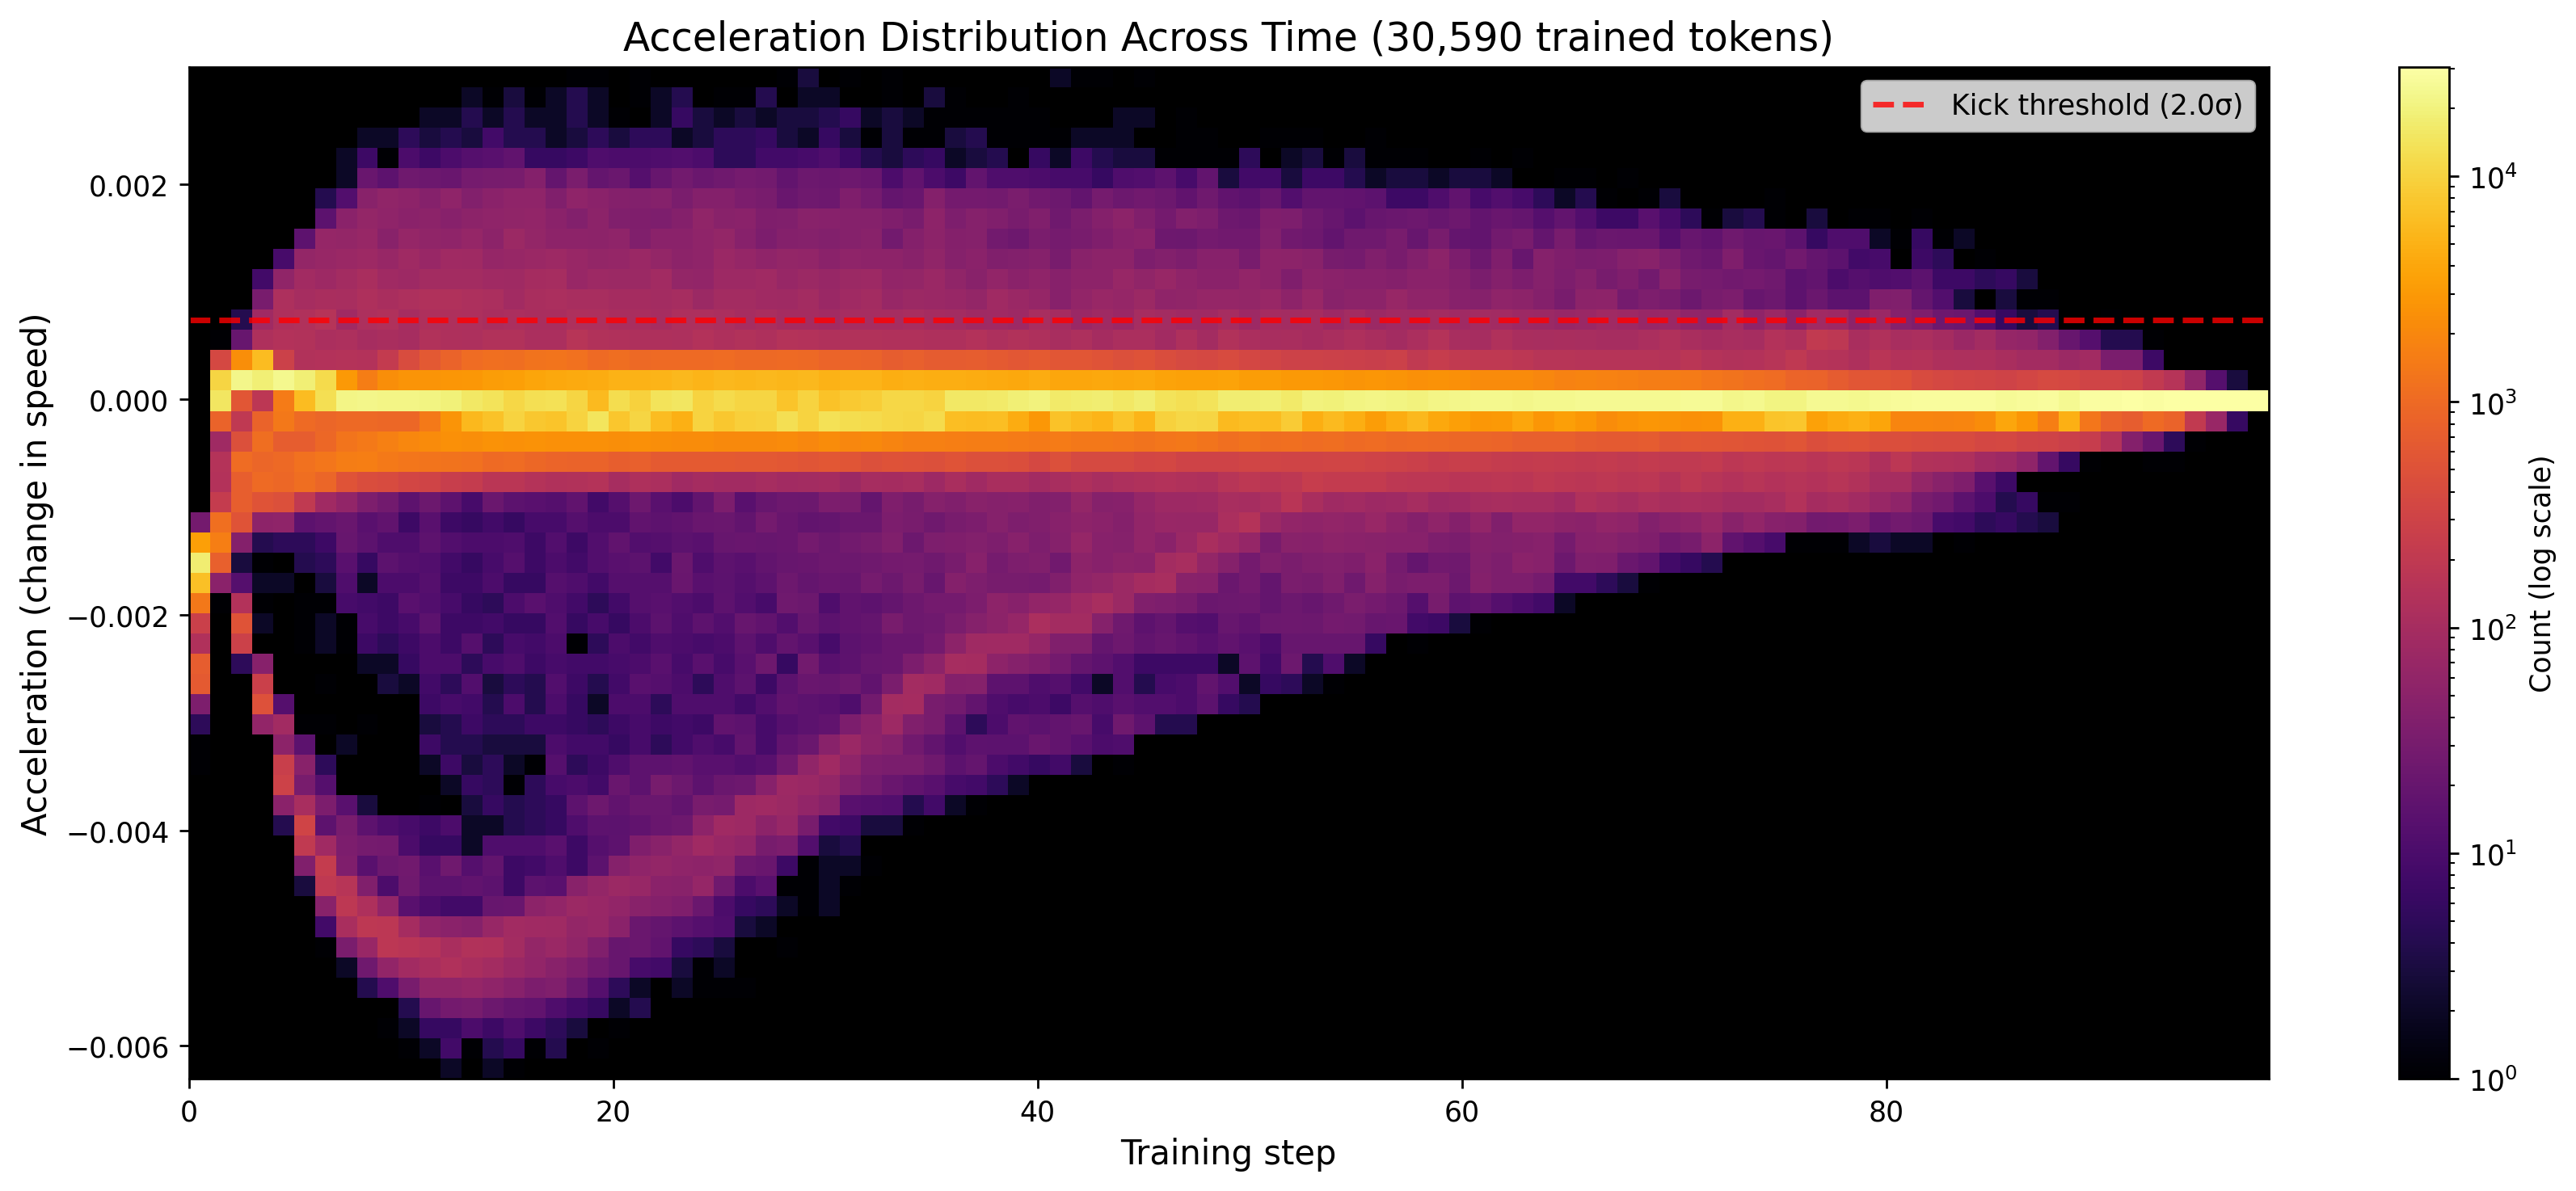

✓ Heatmap complete


In [27]:
print("\nPlotting acceleration heatmap...\n")

fig, ax = plt.subplots(figsize=(14, 6), dpi=PLOT_DPI)
ax.set_facecolor('black')

# Flatten data for 2D histogram
timesteps_flat = np.repeat(np.arange(accelerations.shape[0]), accelerations.shape[1])
accel_flat = accelerations.flatten().numpy()

# 2D histogram
h = ax.hist2d(timesteps_flat, accel_flat, bins=[n_steps-2, 50], 
              cmap=COLORMAP, norm=plt.matplotlib.colors.LogNorm())

# Add kick threshold line
ax.axhline(kick_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Kick threshold ({KICK_THRESHOLD_SIGMA}σ)', alpha=0.8)

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Acceleration (change in speed)', fontsize=12)
ax.set_title(f'Acceleration Distribution Across Time ({n_trained:,} trained tokens)', fontsize=14)
ax.legend()
plt.colorbar(h[3], ax=ax, label='Count (log scale)')
plt.tight_layout()
plt.show()

print(f"✓ Heatmap complete")

## Visualization: Displacement Comparison


Plotting displacement comparison...



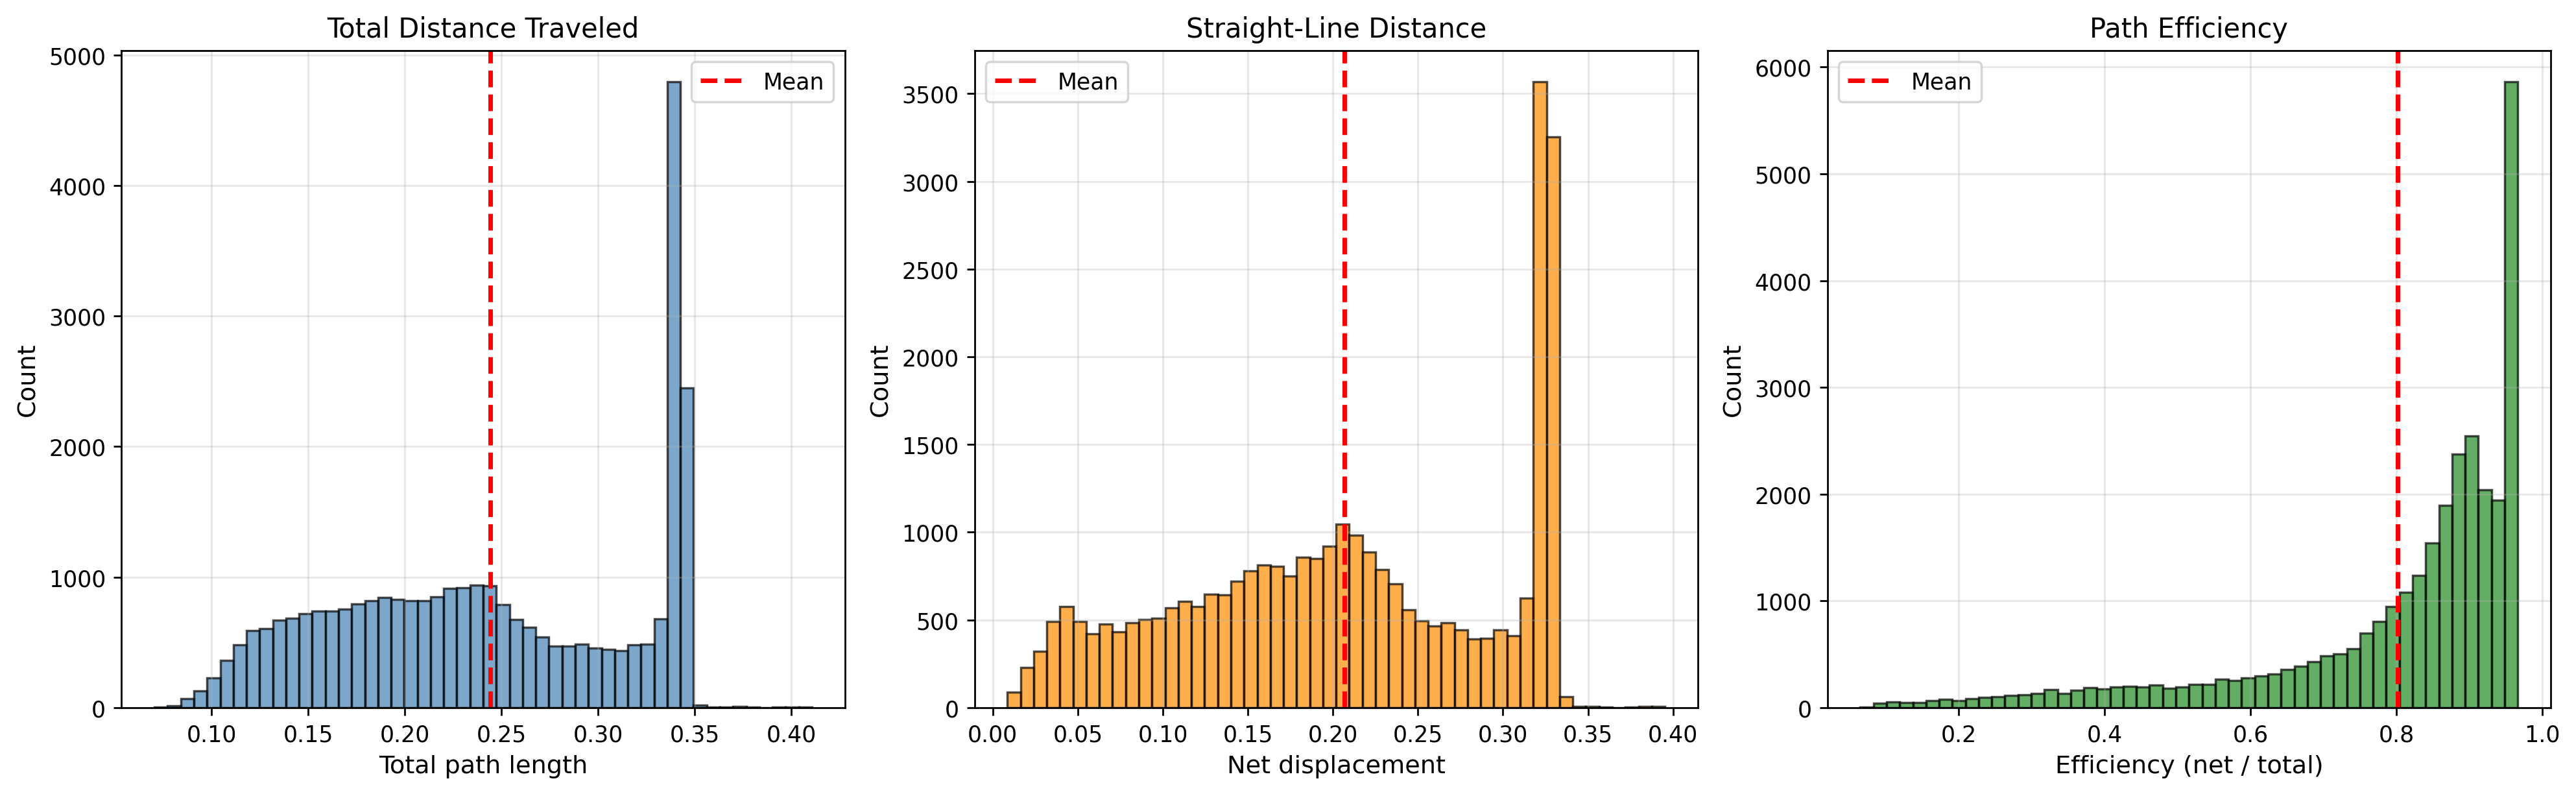

✓ Displacement plots complete


In [28]:
print("\nPlotting displacement comparison...\n")

fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=PLOT_DPI)

# Histogram: Total path length
ax = axes[0]
ax.hist(total_path_length.numpy(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(total_path_length.mean().item(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_xlabel('Total path length', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Total Distance Traveled', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Histogram: Net displacement
ax = axes[1]
ax.hist(net_displacement.numpy(), bins=50, color='darkorange', alpha=0.7, edgecolor='black')
ax.axvline(net_displacement.mean().item(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_xlabel('Net displacement', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Straight-Line Distance', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Histogram: Efficiency
ax = axes[2]
ax.hist(efficiency.numpy(), bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
ax.axvline(efficiency.mean().item(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_xlabel('Efficiency (net / total)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Path Efficiency', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Displacement plots complete")

## Visualization: Radial vs Tangential Velocity


Plotting radial vs tangential velocity...



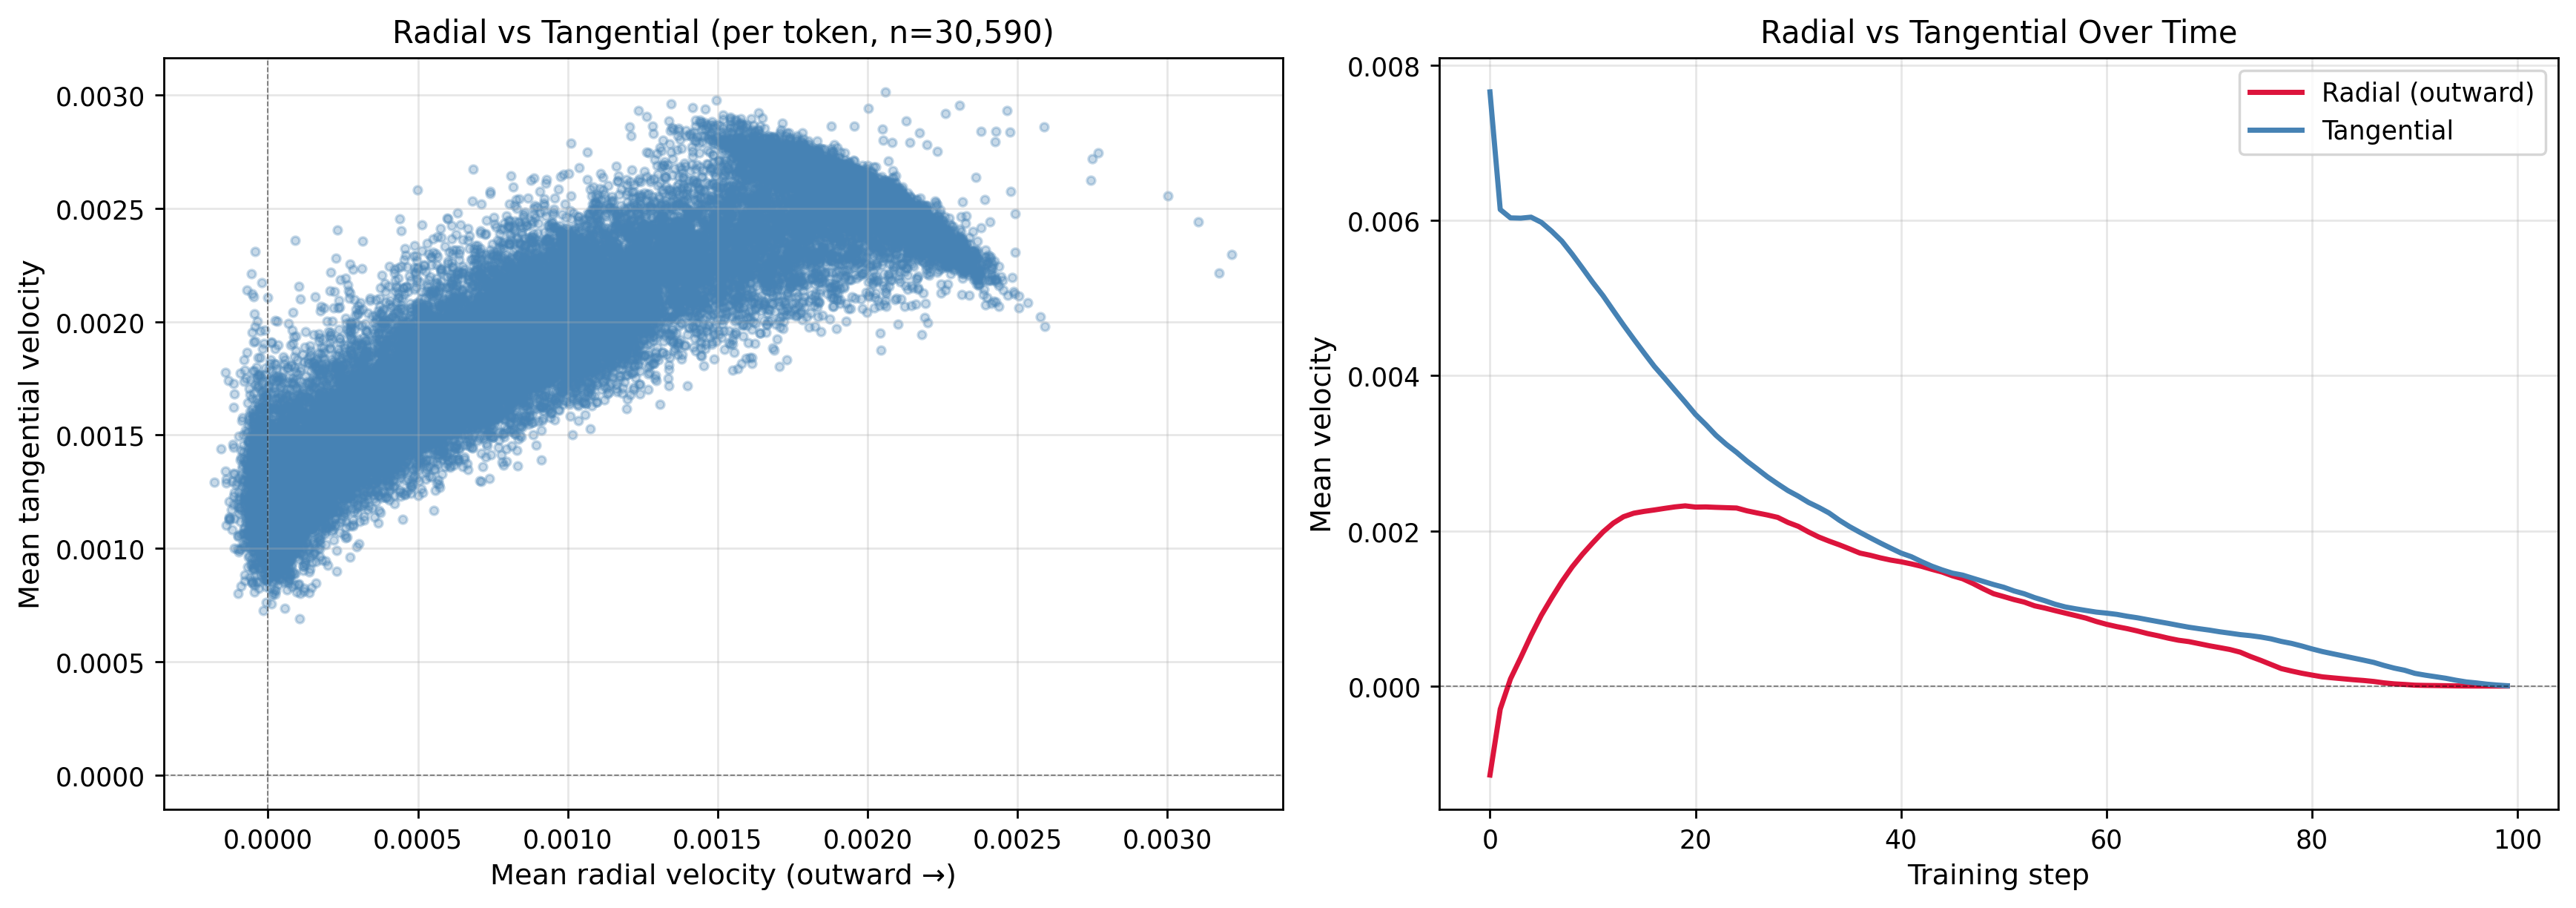

✓ Radial analysis plots complete


In [29]:
print("\nPlotting radial vs tangential velocity...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=PLOT_DPI)

# Scatter: radial vs tangential (averaged over time)
ax = axes[0]
v_r_mean = radial_velocities.mean(dim=0).numpy()
v_t_mean = tangential_velocities.mean(dim=0).numpy()
ax.scatter(v_r_mean, v_t_mean, alpha=0.3, s=10, c='steelblue')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
ax.axvline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
ax.set_xlabel('Mean radial velocity (outward →)', fontsize=11)
ax.set_ylabel('Mean tangential velocity', fontsize=11)
ax.set_title(f'Radial vs Tangential (per token, n={n_trained:,})', fontsize=12)
ax.grid(True, alpha=0.3)

# Time series: mean radial/tangential over all tokens
ax = axes[1]
steps = np.arange(n_steps - 1)
ax.plot(steps, radial_velocities.mean(dim=1).numpy(), label='Radial (outward)', linewidth=2, color='crimson')
ax.plot(steps, tangential_velocities.mean(dim=1).numpy(), label='Tangential', linewidth=2, color='steelblue')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
ax.set_xlabel('Training step', fontsize=11)
ax.set_ylabel('Mean velocity', fontsize=11)
ax.set_title('Radial vs Tangential Over Time', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Radial analysis plots complete")

## Visualization: Kick Timeline


Plotting kick timeline...



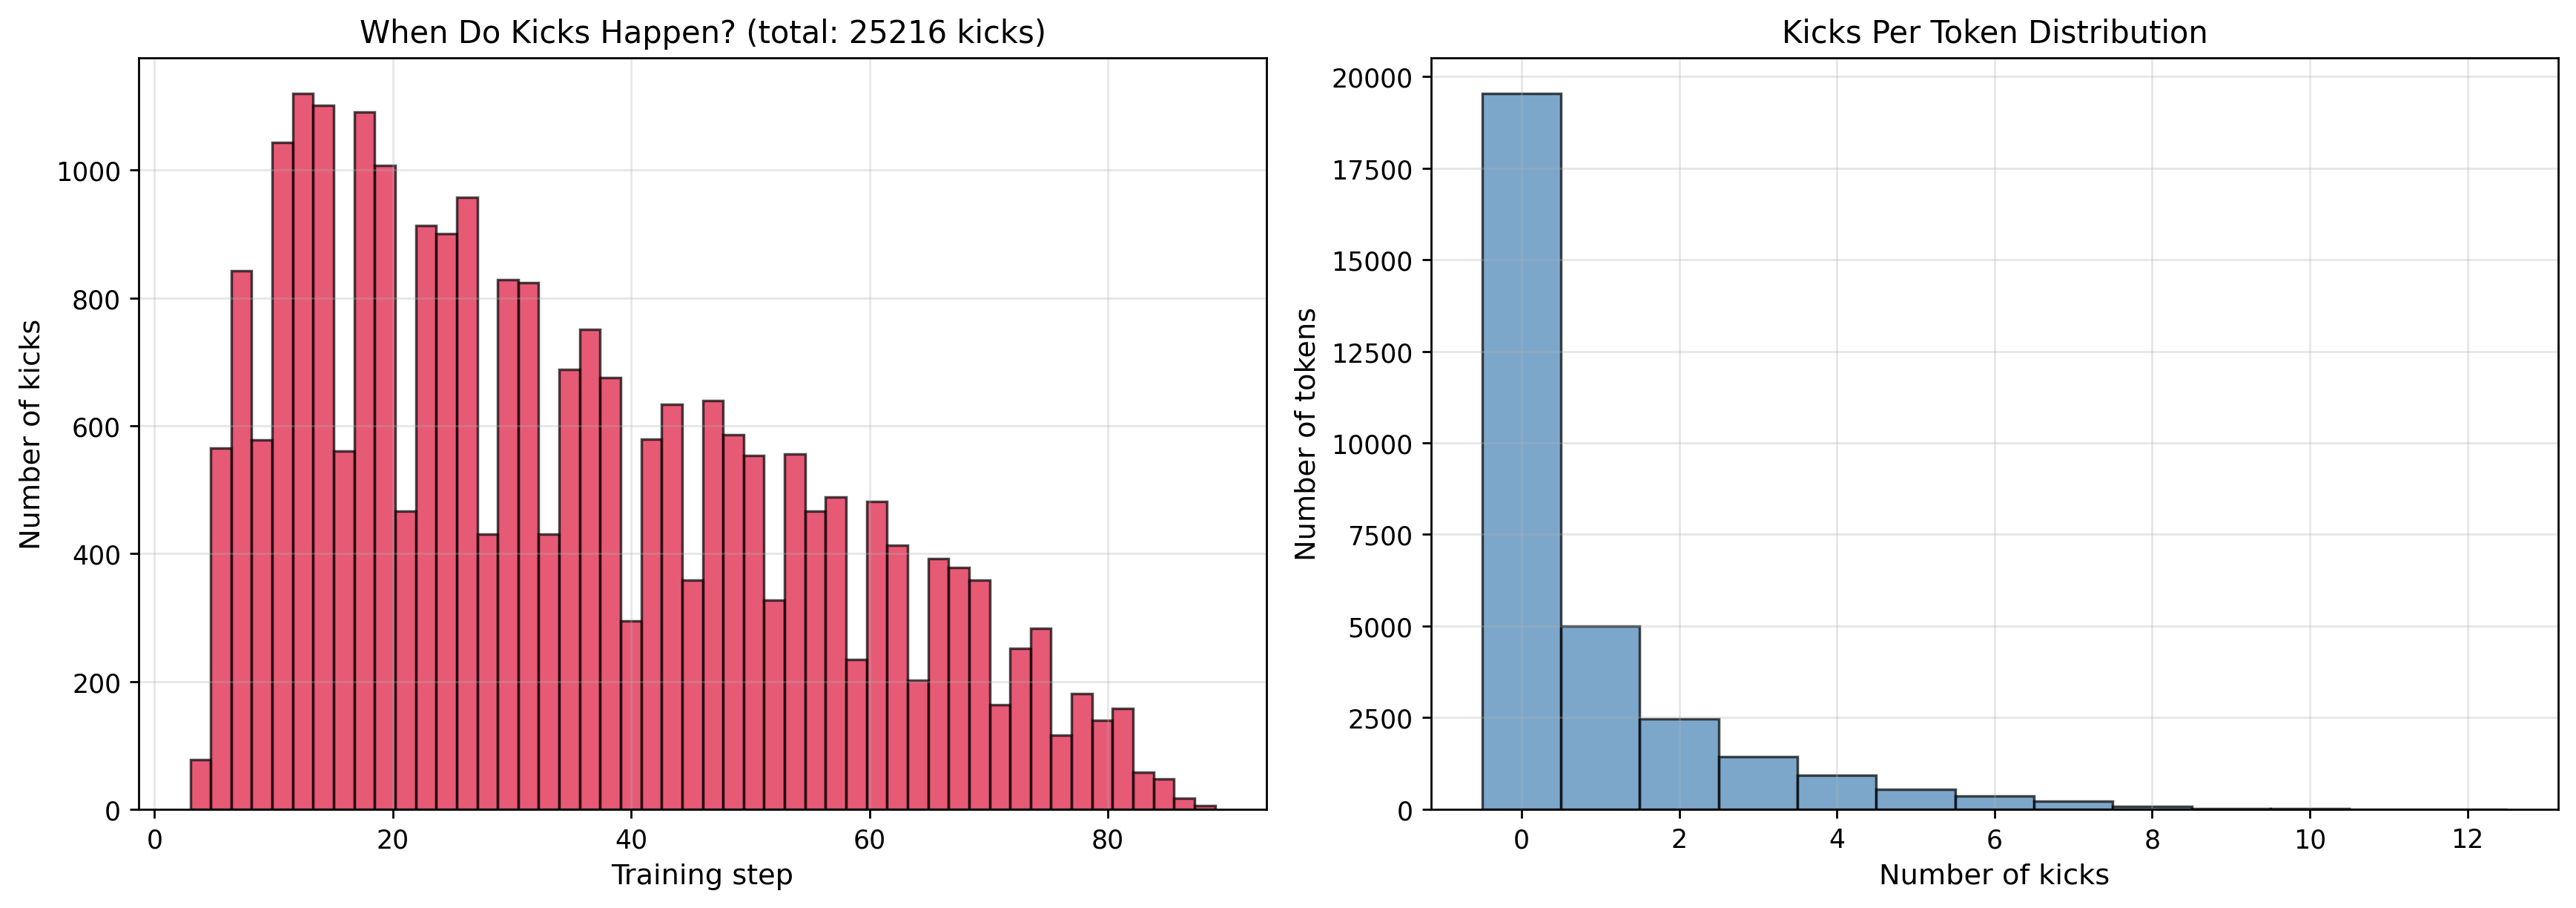

✓ Kick timeline plots complete


In [30]:
print("\nPlotting kick timeline...\n")

if len(all_kick_times) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=PLOT_DPI)
    
    # Histogram of kick times
    ax = axes[0]
    ax.hist(all_kick_times, bins=min(50, n_steps-2), color='crimson', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Training step', fontsize=11)
    ax.set_ylabel('Number of kicks', fontsize=11)
    ax.set_title(f'When Do Kicks Happen? (total: {len(all_kick_times)} kicks)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Distribution of kicks per token
    ax = axes[1]
    ax.hist(kicks_per_token.numpy(), bins=range(int(kicks_per_token.max().item())+2), 
            color='steelblue', alpha=0.7, edgecolor='black', align='left')
    ax.set_xlabel('Number of kicks', fontsize=11)
    ax.set_ylabel('Number of tokens', fontsize=11)
    ax.set_title(f'Kicks Per Token Distribution', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Kick timeline plots complete")
else:
    print("Skipping kick timeline (no kicks detected)")

## Summary

In [31]:
print(f"\n{'='*80}")
print(f"KICK ANALYSIS SUMMARY")
print(f"{'='*80}\n")

print(f"Dataset: {TRAINING_DATA_PATH}")
print(f"  Steps: {n_steps}")
print(f"  Trained tokens: {n_trained:,}")
print()

print(f"Displacement:")
print(f"  Mean total path: {total_path_length.mean().item():.4f}")
print(f"  Mean net displacement: {net_displacement.mean().item():.4f}")
print(f"  Mean efficiency: {efficiency.mean().item():.4f} ({'straight' if efficiency.mean() > 0.95 else 'wandering'})")
print()

if len(all_kick_times) > 0:
    print(f"Kicks (threshold: {kick_threshold:.4e}):")
    print(f"  Total kicks: {len(all_kick_times)}")
    print(f"  Mean per token: {kicks_per_token.mean().item():.2f}")
    print(f"  Earliest: step {all_kick_times.min()}")
    print(f"  Latest: step {all_kick_times.max()}")
    print(f"  Early kicks (t<10): {(all_kick_times < 10).sum()} ({100*(all_kick_times < 10).sum()/len(all_kick_times):.1f}%)")
else:
    print(f"Kicks: None detected (threshold may be too high)")
print()

print(f"Directionality:")
print(f"  Mean radial velocity: {radial_velocities.mean().item():.4e} ({'outward' if radial_velocities.mean() > 0 else 'inward'})")
print(f"  Mean tangential velocity: {tangential_velocities.mean().item():.4e}")
print(f"  Radial fraction: {radial_fraction.mean().item():.4f} ({'mostly radial' if radial_fraction.mean() > 0.7 else 'mixed'})")
print()

print(f"Key observations:")
if efficiency.mean() > 0.95:
    print(f"  ✓ Tokens move in nearly straight lines (ballistic motion)")
elif efficiency.mean() > 0.7:
    print(f"  ⚠️ Tokens wander moderately (some curvature)")
else:
    print(f"  ⚠️ Tokens wander significantly (diffusive or orbital motion)")

if radial_velocities.mean() > 0:
    print(f"  ✓ Net outward motion (explosion from origin)")
else:
    print(f"  ⚠️ Net inward or zero radial motion")

if len(all_kick_times) > 0 and (all_kick_times < 10).sum() / len(all_kick_times) > 0.5:
    print(f"  ✓ Most kicks happen early (initial impulse)")
elif len(all_kick_times) > 0:
    print(f"  ⚠️ Kicks distributed throughout training")

print(f"\n{'='*80}")


KICK ANALYSIS SUMMARY

Dataset: ../tensors/Wordybird/1.12c_wordybird_1.safetensors
  Steps: 101
  Trained tokens: 30,590

Displacement:
  Mean total path: 0.2442
  Mean net displacement: 0.2068
  Mean efficiency: 0.8020 (wandering)

Kicks (threshold: 7.3827e-04):
  Total kicks: 25216
  Mean per token: 0.82
  Earliest: step 3
  Latest: step 89
  Early kicks (t<10): 2064 (8.2%)

Directionality:
  Mean radial velocity: 1.0374e-03 (outward)
  Mean tangential velocity: 1.9993e-03
  Radial fraction: 0.2966 (mixed)

Key observations:
  ⚠️ Tokens wander moderately (some curvature)
  ✓ Net outward motion (explosion from origin)
  ⚠️ Kicks distributed throughout training

